# NGC6791

In [497]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.optimize import curve_fit

import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 8]

### Define functions

In [498]:
def gminusv(gbp_grp):
    """Given G_BP - G_RP, get G_V.
    From Johnson-Cousins Relationship
    """
    b = -0.01760
    m1 = -0.006860
    m2 = -0.1732
    g_v = m2*(gbp_grp)**2 + m1*(gbp_grp) + b
    return g_v

def gminusI(gbp_grp):
    """Given G_BP - G_RP, get G_I.
    From Johnson-Cousins Relationship
    """
    b = 0.02085
    m1 = 0.7419
    m2 = -0.09631
    g_I = m2*(gbp_grp)**2 + m1*(gbp_grp) + b
    return g_I

def cut_box(length, pmra, pmdec, bounds):
    
    """
    bounds = [ramin, ramax, decmin, decmax]
    
    Returns: None
    """
    for i in range(length):
        if pmra[i] < bounds[0] or pmra[i] > bounds[1] or pmdec[i] < bounds[2] or pmdec[i] > bounds[3]:
            pmra[i] = np.nan
            pmdec[i] = np.nan
            
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))


def fit_gauss(x, p0, RA=True, Dec=False, nplot='3'):
    
    bin_heights, bin_borders, _ = plt.hist(x, bins='auto', label='histogram', color='forestgreen');
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=p0)

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit', c='deeppink')
    plt.legend()

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    if RA==True:
        plt.xlabel('RA Proper Motions (deg)', fontsize=25)
        plt.title('NGC6791 RA Proper Motions (No Cluster Vetting)', fontsize=25)
        plt.savefig('NGC6791/Plot3_NGC6791_RAProperMotions.png', dpi=150)
        
    elif Dec==True:
        plt.xlabel('Dec Proper Motions (deg)', fontsize=25)
        plt.title('NGC6791 Dec Proper Motions (No Cluster Vetting)', fontsize=25)
        plt.savefig('NGC6791/Plot3_NGC6791_DecProperMotions.png', dpi=150)


    
    return popt


def isInside(circle_x, circle_y, rad, x, y):
        
    """Is x, y inside circle?
    """
    if ((x - circle_x) * (x - circle_x) + 
        (y - circle_y) * (y - circle_y) <= rad * rad):
        return True
    else:
        return False

    
def EV_I(AV):
    """
    Given Av, get E(V-I).
    
    """
    
    return AV/2.5

def V_I0(AV, V_I):
    
    """
    Given Av and V-I, get (V-I) - E(V-I).
    
    """
    
    return V_I-EV_I(AV)

def parallax_dist(mean_parallax):
    """
    Given parallax (arcsec), get distance (parsecs).
    
    """
    
    return 1./mean_parallax

def parallax_dist_errprop(parallax, parallax_err):
    """
    Given parallax error (arcsec), get distance error (parsecs).
    
    """
    return parallax_err/parallax
    

def dist_mag(dist, appmag, Av):
    """
    Distance modulus equation.
    Given distance, apparent mag, and Av, get absolute mag.
    
    """
    
    absmag = -1*(5*np.log10(dist)-5+Av-appmag)
    return absmag


def dist_mag_errprop(dist, delAv, deldist):
    """
    Distance modulus error propogation.
    Given distance, apparent mag, and Av, get absolute mag.
    
    """
    
    delA = 5*0.434*(deldist/dist)
    delM = np.sqrt(delAv**2 + delA**2)
    return delM

# Converting Gaia magnitude to V and I bands

In [531]:
# Read CSV of Gaia data
NGC6791df = pd.read_csv('res/NGC6791-result.csv')
NGC6791df = NGC6791df.dropna()


In [532]:
NGC6791df

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
1,2051103005634632576,290.402192,37.728758,0.221370,0.133630,-1.071632,0.245700,-4.537498,0.251778,18.290333,18.697254,17.672104
2,2051104684962399872,290.328377,37.736965,-0.043204,0.268798,-0.378404,0.461597,-2.336604,0.650356,19.345230,19.811317,18.610933
3,2051105307737300224,290.276831,37.760518,0.286548,0.086504,-0.675967,0.156174,-2.037715,0.190547,17.361050,17.806301,16.763836
4,2051103967707147648,290.314773,37.678723,0.036567,0.033555,-2.786502,0.055676,-4.437623,0.070050,15.650310,16.387870,14.821195
5,2051104066489830144,290.300098,37.688282,0.286258,0.165589,-0.651765,0.294707,-1.965336,0.357034,18.603850,19.023016,17.892563
...,...,...,...,...,...,...,...,...,...,...,...,...
9698,2051297958486975872,290.188063,37.904714,1.277836,0.685183,0.239157,1.052911,-0.020603,1.476099,20.458760,20.993727,19.524828
9699,2051298095935683072,290.155944,37.910553,-1.331339,0.638337,-4.127084,1.129448,-11.784018,1.178211,18.898943,19.181330,18.186060
9700,2051297924137037312,290.177932,37.909977,0.342134,0.322285,-2.630746,0.541462,-3.493467,0.675873,19.535442,19.832022,18.889828
9701,2051297859708794880,290.182179,37.887271,-0.417739,0.322420,-4.110237,0.566315,-5.958975,0.687977,19.585413,20.055010,18.847359


In [501]:
pmra = np.array(NGC6791df['pmra'])
pmdec = np.array(NGC6791df['pmdec'])

pmra0 = np.array(NGC6791df['pmra'])
pmdec0 = np.array(NGC6791df['pmdec'])

ra0 = np.array(NGC6791df['ra'])
dec0 = np.array(NGC6791df['dec'])

In [502]:
# Get G_V and G_I for all stars in sample

g_v = gminusv(NGC6791df['phot_bp_mean_mag']-NGC6791df['phot_rp_mean_mag'])

g_I = gminusI(NGC6791df['phot_bp_mean_mag']-NGC6791df['phot_rp_mean_mag'])

In [503]:
# Get V mag and I mag for all stars in sample

V = -1*(g_v - NGC6791df['phot_g_mean_mag'])
I = -1*(g_I - NGC6791df['phot_g_mean_mag'])

# Get V-I mag for all stars in sample

V_I = V-I

# Step 4 - Color-Magnitude Diagram

Here, I plot a color-magnitude diagram based on the color (V-I) and V magnitude calculated above.

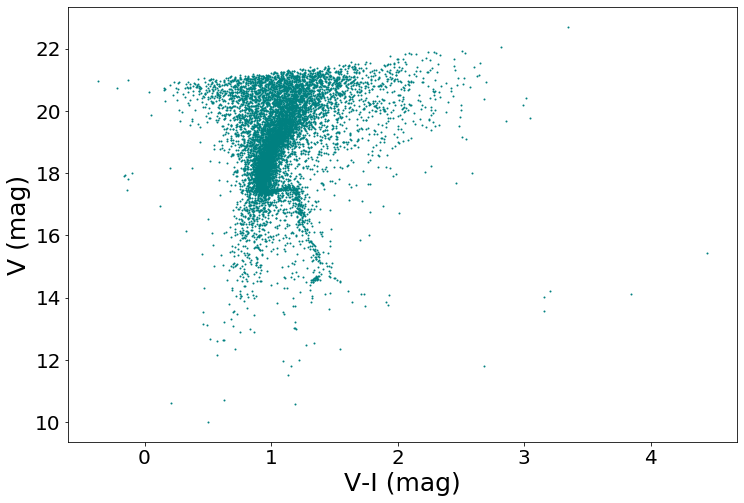

In [504]:
plt.scatter(V_I, V, s=1.0, c='teal')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('V-I (mag)', fontsize=25)
plt.ylabel('V (mag)', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot1.png', dpi=150)

# Step 5: Proper Motions

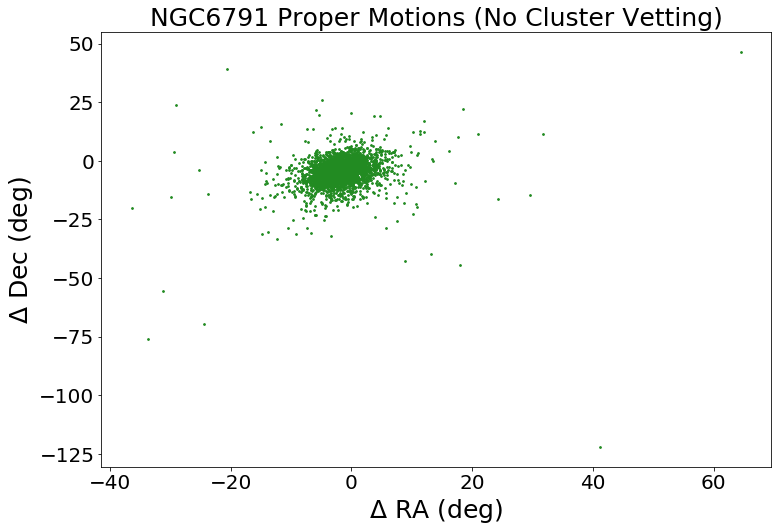

In [505]:
plt.scatter(pmra, pmdec, s=3, c='forestgreen')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('NGC6791 Proper Motions (No Cluster Vetting)', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot2.png', dpi=150)

# Step 6: Determine the Center

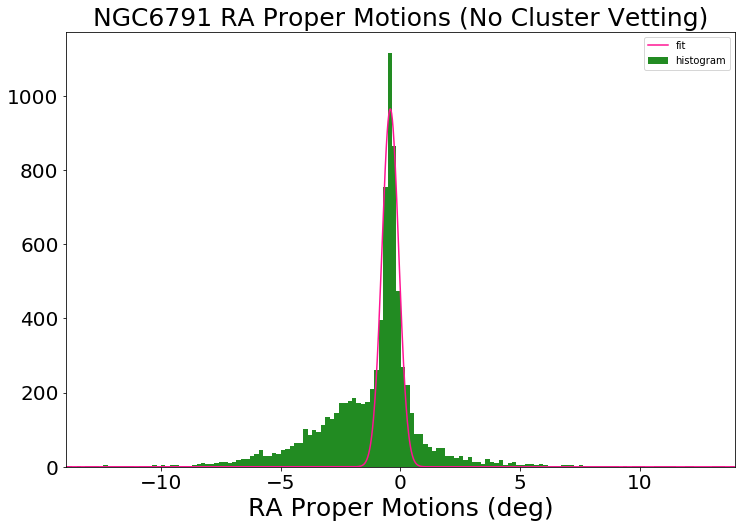

In [506]:
init_guess_a = [-1., 120., 10.]
plt.xlim(-14, 14)

ra_center, _, ra_sig = fit_gauss(pmra, init_guess_a)

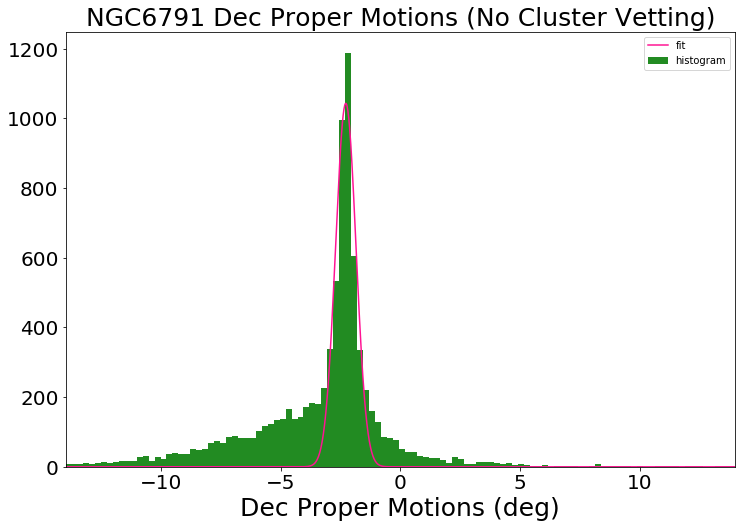

In [507]:
init_guess_b = [-3., 110., 5.]
plt.xlim(-14, 14)

dec_center, _, dec_sig = fit_gauss(pmdec, init_guess_b, RA=False, Dec=True)

In [508]:
# Convert parallax to arcseconds

NGC6791df.insert(12, "parallax_arcsec", NGC6791df['parallax']/1000., True)
NGC6791df.insert(13, "parallax_err_arcsec", NGC6791df['parallax_error']/1000., True)

NGC6791df.insert(14, "distance_parsec", parallax_dist(NGC6791df['parallax_arcsec']), True)
NGC6791df.insert(15, "distance_err_parsec", parallax_dist_errprop(NGC6791df['parallax_arcsec'], NGC6791df['parallax_err_arcsec']))


#NGC6791df = NGC6791df.drop(NGC6791df[NGC6791df.distance_parsec > 1800].index)

In [509]:
pmsig = np.mean((abs(ra_sig), abs(dec_sig)))

In [510]:
for index, row in NGC6791df.iterrows():
    
    if not isInside(ra_center, dec_center, 3*pmsig, row['pmra'], row['pmdec']):
        NGC6791df = NGC6791df.drop(index)

In [511]:
pmra = np.array(NGC6791df['pmra'])
pmdec = np.array(NGC6791df['pmdec'])

g_v = gminusv(NGC6791df['phot_bp_mean_mag']-NGC6791df['phot_rp_mean_mag'])
g_I = gminusI(NGC6791df['phot_bp_mean_mag']-NGC6791df['phot_rp_mean_mag'])

V = -1*(g_v - NGC6791df['phot_g_mean_mag'])
I = -1*(g_I - NGC6791df['phot_g_mean_mag'])

V_I = V-I

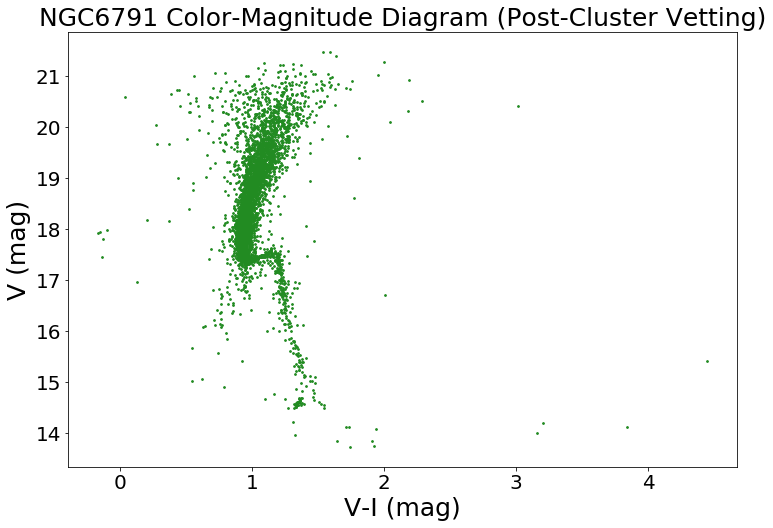

In [512]:
plt.scatter(V_I, V, s=3, c='forestgreen')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('V-I (mag)', fontsize=25)
plt.ylabel('V (mag)', fontsize=25)
plt.title('NGC6791 Color-Magnitude Diagram (Post-Cluster Vetting)', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot4.png', dpi=150)

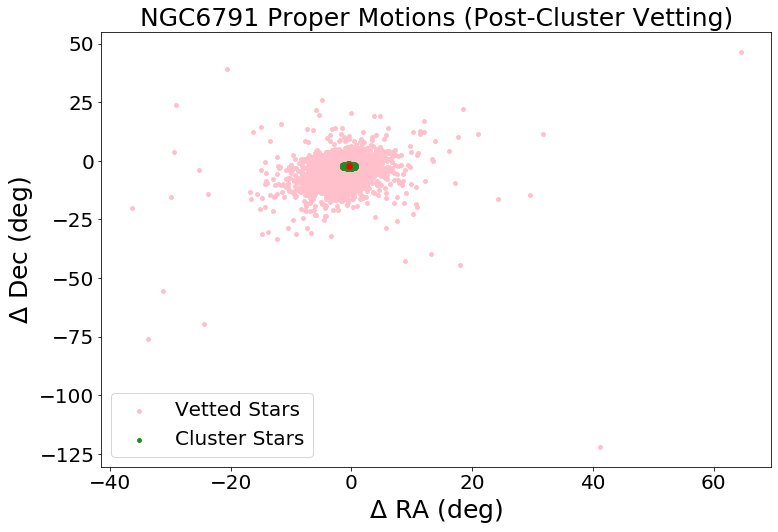

In [513]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(pmra0, pmdec0, s=15, c='pink', label='Vetted Stars')
ax.scatter(pmra, pmdec, s=15, color='forestgreen', label='Cluster Stars')
ax.scatter(ra_center, dec_center, c='r', s=30)

#plt.xlim(-5, 0)
#plt.ylim(-5, 0)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('NGC6791 Proper Motions (Post-Cluster Vetting)', fontsize=25)
plt.legend(fontsize=20);

plt.savefig('NGC6791/NGC6791_Plot5.png', dpi=150)

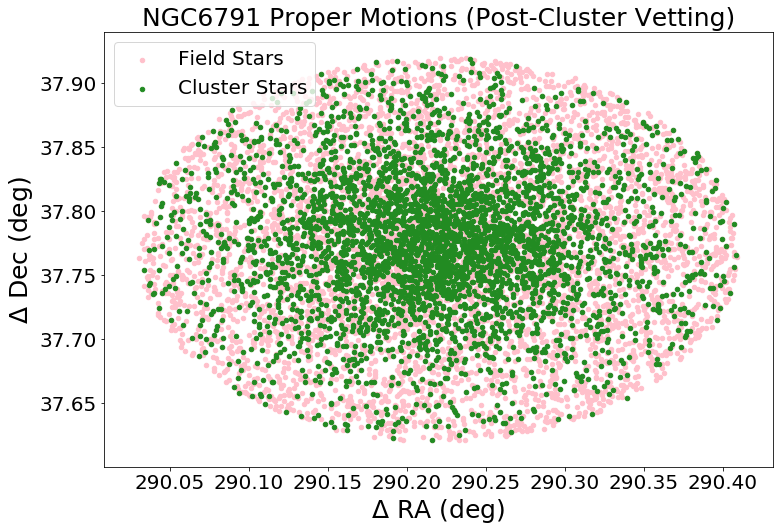

In [514]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(ra0, dec0, s=20, c='pink', label='Field Stars')
ax.scatter(NGC6791df['ra'], NGC6791df['dec'], s=20, color='forestgreen', label='Cluster Stars')

#plt.xlim(-12, -10)
#plt.ylim(-4, -2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('NGC6791 Proper Motions (Post-Cluster Vetting)', fontsize=25)
plt.legend(fontsize=20);

plt.savefig('NGC6791/NGC6791_Plot6.png', dpi=150)

# Step 7 - Parallax Histogram

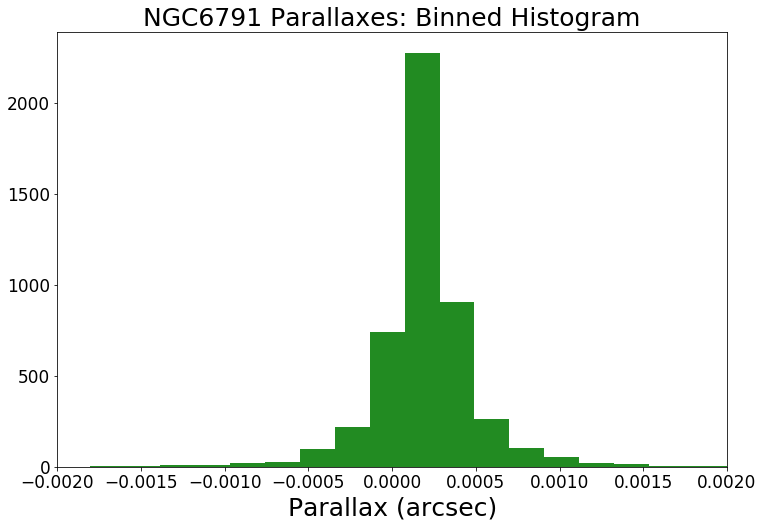

In [515]:
plt.hist(NGC6791df['parallax_arcsec'], bins=40, density=True, color='forestgreen');

plt.xlim(-0.002, 0.002)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Parallax (arcsec)', fontsize=25)
plt.title('NGC6791 Parallaxes: Binned Histogram', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot7.png', dpi=150)

In [516]:
parallax_arcs = np.median(NGC6791df['parallax_arcsec'])
parallax_err_arcs = np.std(NGC6791df['parallax_arcsec'])/np.sqrt(len(NGC6791df))

print('Mean cluster parallax (arcs): ', parallax_arcs)
print('Sigma of cluster parallax (arcs): ', parallax_err_arcs)

Mean cluster parallax (arcs):  0.0001912189609154014
Sigma of cluster parallax (arcs):  5.353845951746581e-06


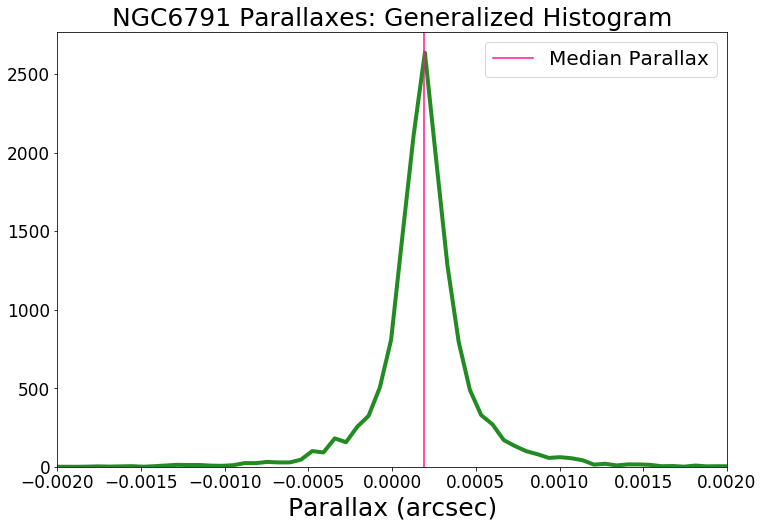

In [517]:
sns.distplot(NGC6791df['parallax_arcsec'], hist=False, kde=True, 
             bins=25, color = 'forestgreen',
             kde_kws={'linewidth': 4},)

plt.axvline(np.median(NGC6791df['parallax_arcsec']), color='deeppink', label='Median Parallax')

plt.xlim(-0.002, 0.002)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.xlabel('Parallax (arcsec)', fontsize=25)
plt.title('NGC6791 Parallaxes: Generalized Histogram', fontsize=25)
plt.legend(fontsize=20)

plt.savefig('NGC6791/NGC6791_Plot8.png', dpi=150)

### Define Av

In [519]:
Av = 0.425

# Step 9: Stellar Parallax

Get Stellar Distances, Absolute V mag, Absolute I mag, and Absolute V-I for all stars in cluster.

In [520]:
NGC6791_dists = np.zeros(len(NGC6791df))
NGC6791_absV = np.zeros(len(NGC6791df))
NGC6791_absI = np.zeros(len(NGC6791df))
NGC6791_absVI = np.zeros(len(NGC6791df))

NGC6791_disterrs = np.zeros(len(NGC6791df))
NGC6791_absVerrs = np.zeros(len(NGC6791df))
NGC6791_absIerrs = np.zeros(len(NGC6791df))
NGC6791_absVIerrs = np.zeros(len(NGC6791df))

V = np.array(V)
I = np.array(I)

i = 0

for index, row in NGC6791df.iterrows():
    NGC6791_dists[i] = parallax_dist(row['parallax_arcsec'])
    NGC6791_disterrs[i] = parallax_dist_errprop(row['parallax_arcsec'], row['parallax_err_arcsec'])
    
    NGC6791_absV[i] = dist_mag(NGC6791_dists[i], V[i], Av)
    NGC6791_absI[i] = dist_mag(NGC6791_dists[i], I[i], Av)
    NGC6791_absVI[i] = NGC6791_absV[i]-NGC6791_absI[i]
    
    
    i+=1

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in log10


In [521]:
# Get (V-I)_0
V_I_naught = V_I0(Av, V_I)

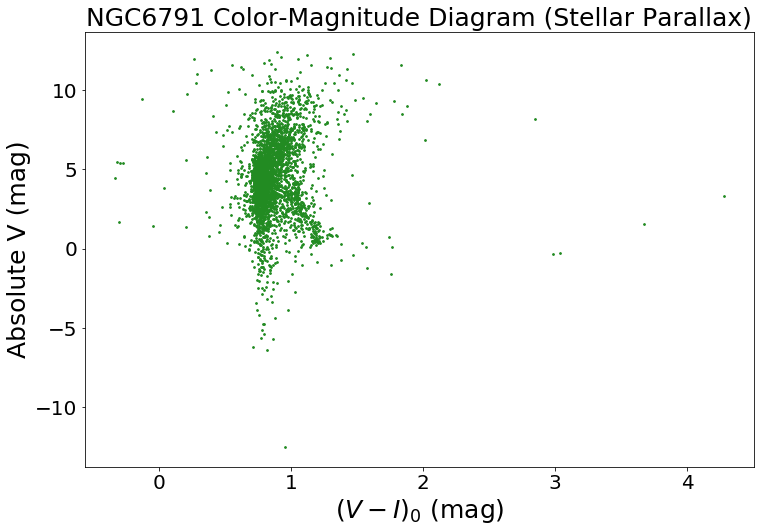

In [522]:
plt.scatter(V_I_naught, NGC6791_absV, s=3, color='forestgreen')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$(V-I)_0$ (mag)', fontsize=25)
plt.ylabel('Absolute V (mag)', fontsize=25)
plt.title('NGC6791 Color-Magnitude Diagram (Stellar Parallax)', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot9.png', dpi=150)


# Step 10: Cluster Parallax

In [523]:
cluster_dist = 1/parallax_arcs
cluster_dist_err = cluster_dist * (parallax_err_arcs/parallax_arcs)

In [524]:
print('Distance to NGC6791: ', cluster_dist, ' parsecs')
print('Distance to NGC6791 Error: ', cluster_dist_err, ' parsecs')

Distance to NGC6791:  5229.606913523693  parsecs
Distance to NGC6791 Error:  146.4212004351482  parsecs


In [525]:
NGC6791_absV_c = np.zeros(len(NGC6791df))
NGC6791_absI_c = np.zeros(len(NGC6791df))
NGC6791_absVI_c = np.zeros(len(NGC6791df))

NGC6791_absVerrs_c = np.zeros(len(NGC6791df))
NGC6791_absIerrs_c = np.zeros(len(NGC6791df))
NGC6791_absVIerrs_c = np.zeros(len(NGC6791df))

i = 0

for index, row in NGC6791df.iterrows():
    NGC6791_absV_c[i] = dist_mag(cluster_dist, V[i], Av)
    NGC6791_absI_c[i] = dist_mag(cluster_dist, I[i], Av)
    NGC6791_absVI_c[i] = NGC6791_absV_c[i]-NGC6791_absI_c[i]
    
    i+=1

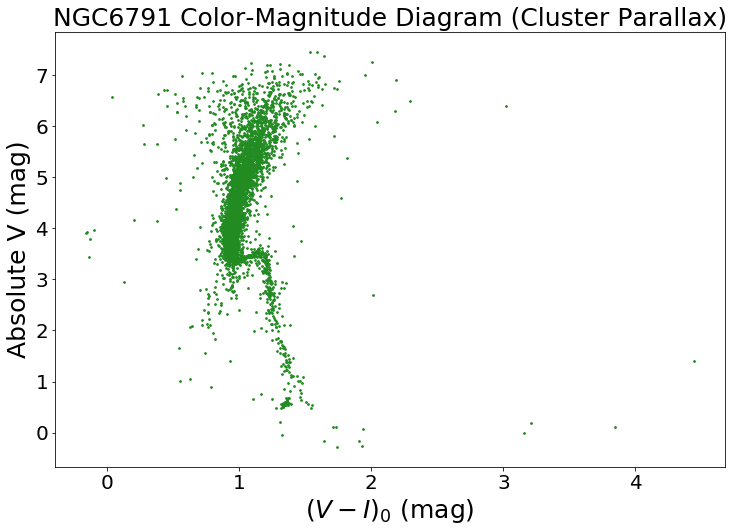

In [526]:
plt.scatter(NGC6791_absVI_c, NGC6791_absV_c, s=3, color='forestgreen')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$(V-I)_0$ (mag)', fontsize=25)
plt.ylabel('Absolute V (mag)', fontsize=25)
plt.title('NGC6791 Color-Magnitude Diagram (Cluster Parallax)', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot10.png', dpi=150)

# Step 12: Luminosity Function

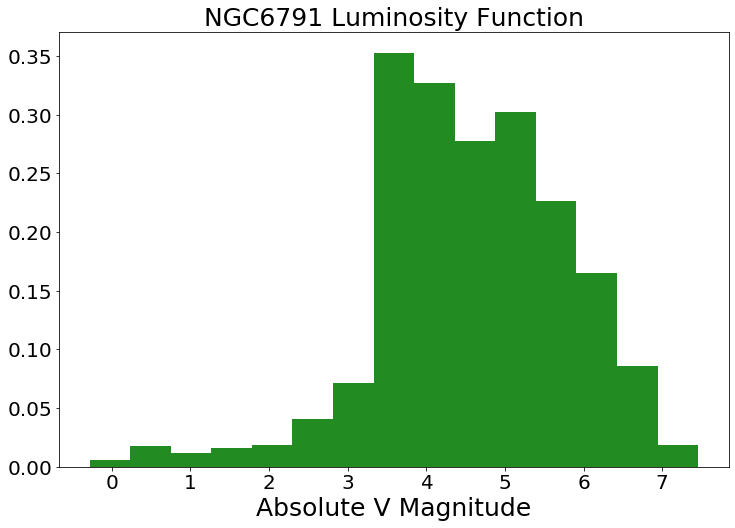

In [527]:
plt.hist(NGC6791_absV_c, bins=15, density=1, color='forestgreen');
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('NGC6791 Luminosity Function', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot11.png', dpi=150)

np.savetxt("NGC6791lumfunc.csv", NGC6791_absV_c, delimiter=',')

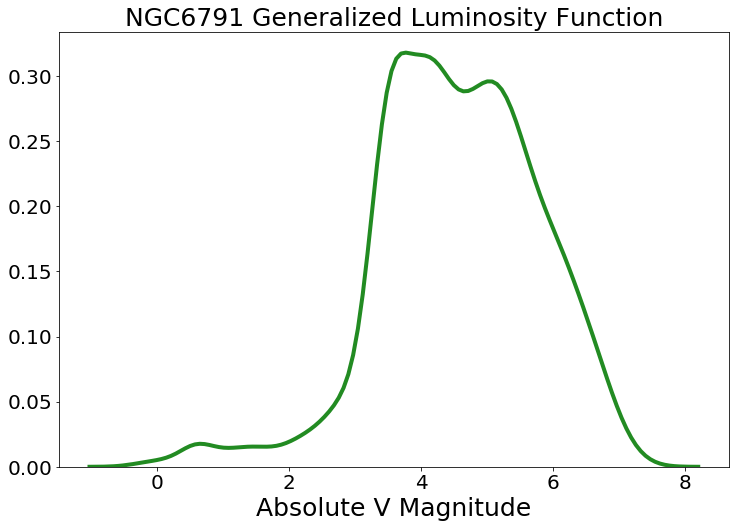

In [528]:
sns.distplot(NGC6791_absV_c, hist=False, kde=True, 
             bins=25, color = 'forestgreen',
             kde_kws={'linewidth': 4},)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('NGC6791 Generalized Luminosity Function', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot12.png', dpi=150)

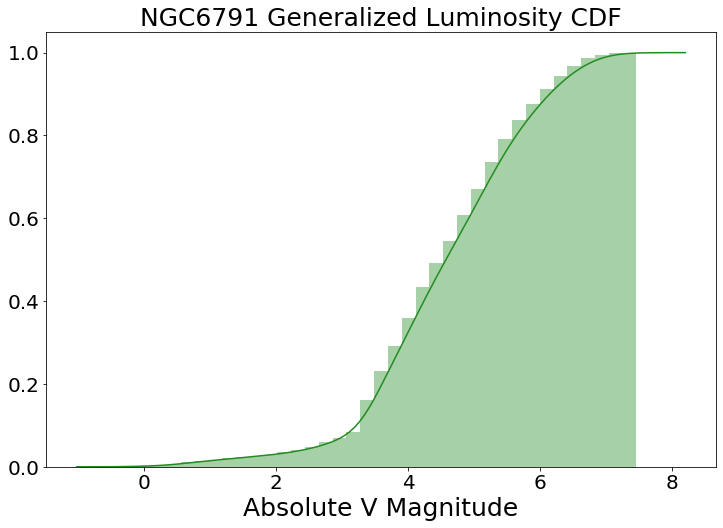

In [529]:
kwargs = {'cumulative': True}
sns.distplot(NGC6791_absV_c, hist_kws=kwargs, kde_kws=kwargs, color = 'forestgreen')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('NGC6791 Generalized Luminosity CDF', fontsize=25)

plt.savefig('NGC6791/NGC6791_Plot13.png', dpi=150)